In [13]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
import torch
import numpy as np
from src.plotting import plot_train_test_split, plot_grid

In [14]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 100
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 3
N_SYSTEMS = 55
RADIUS = 0.35
COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [15]:
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 0 sec



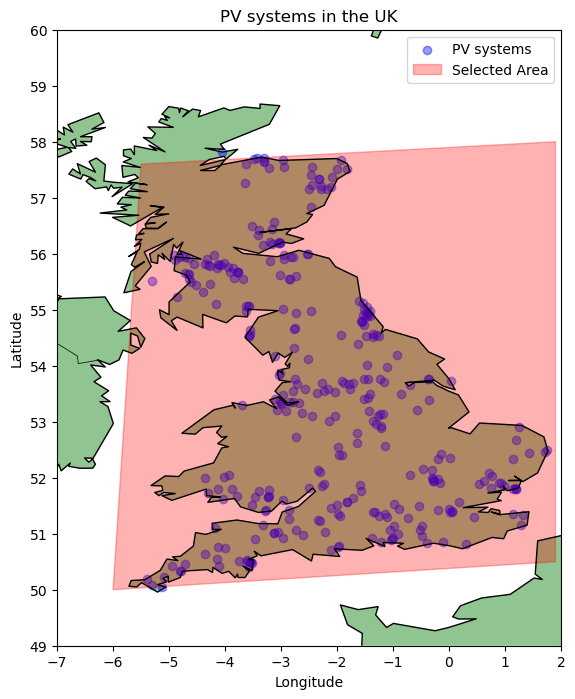

In [16]:
plot_grid(df_location, POLY_COORDS, distance_method='poly')

In [17]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly')

time, y = loader.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [18]:
periodic_time = dl.periodic_mapping(time, day_min=DAY_MIN, day_max=DAY_MAX, minute_interval=MINUTE_INTERVAL)

In [19]:
def cross_val_folds(y, periodic_time, n_days, daily_points):
    """
    Splits the data into n_days folds
    """
    interval = int(n_days * daily_points)
    y_list = [y[i:i+interval] for i in range(0, len(y), interval)]
    periodic_time_list = [periodic_time[i:i+interval] for i in range(0, len(periodic_time), interval)]
    time = torch.arange(0, len(y_list[0]))

    return y_list, periodic_time_list, time



In [20]:
y_list, periodic_time_list, time = cross_val_folds(y, periodic_time, 5, DAILY_DATA_POINTS)

In [21]:
def train_test_split_fold(y_list, periodic_time_list, n_hours_pred, daily_points, day_min, day_max):
    """ 
    Split the data into train and test sets
    The test set is a random hour between 8 and 16 - N for all folds 
    (where N is the number of hours to predict). That will avoid 
    discontinuity and facilitates predictions at different times of 
    the day.

    Args: 
        y (list): the list of y values
        periodic_time (list): list of periodic times
        n_hours_pred (int): the number of hours to predict
        daily_points (int): the number of data points per day
    """ 
    assert daily_points % (day_max - day_min) == 0, "daily_points must be divisible by day_max - day_min"
    assert len(y_list) == len(periodic_time_list), "y_list and periodic_time_list must have the same length"
    
    y_train = []
    y_test = []
    
    time_train = []
    time_test = []

    periodic_train = []
    periodic_test = []
    
    hourly_data_points = daily_points // (day_max - day_min) 
    
    # indexes going backwards from the end of the array
    min_start_idx = int(n_hours_pred * hourly_data_points)
    max_start_idx = int(daily_points)
    
    for i in range(len(y_list)):

        last_hr_idx = np.random.randint(min_start_idx, max_start_idx)
        start_idx = last_hr_idx + int((n_hours_pred * hourly_data_points))

        y_train.append(y_list[i][:-start_idx])
        y_test.append(y_list[i][-start_idx:-last_hr_idx])

        periodic_train.append(periodic_time_list[i][:-start_idx])
        periodic_test.append(periodic_time_list[i][-start_idx:-last_hr_idx])

        _time = torch.arange(0, len(y_train[-1]) + len(y_test[-1]))

        time_train.append(_time[:-len(y_test[-1])])
        time_test.append(_time[-len(y_test[-1]):])

    return y_train, y_test, periodic_train, periodic_test, time_train, time_test

        
        

In [22]:
y_train, y_test, periodic_train, periodic_test, time_train, time_test =  train_test_split_fold(y_list, periodic_time_list, N_HOURS_PRED, DAILY_DATA_POINTS, DAY_MIN, DAY_MAX)


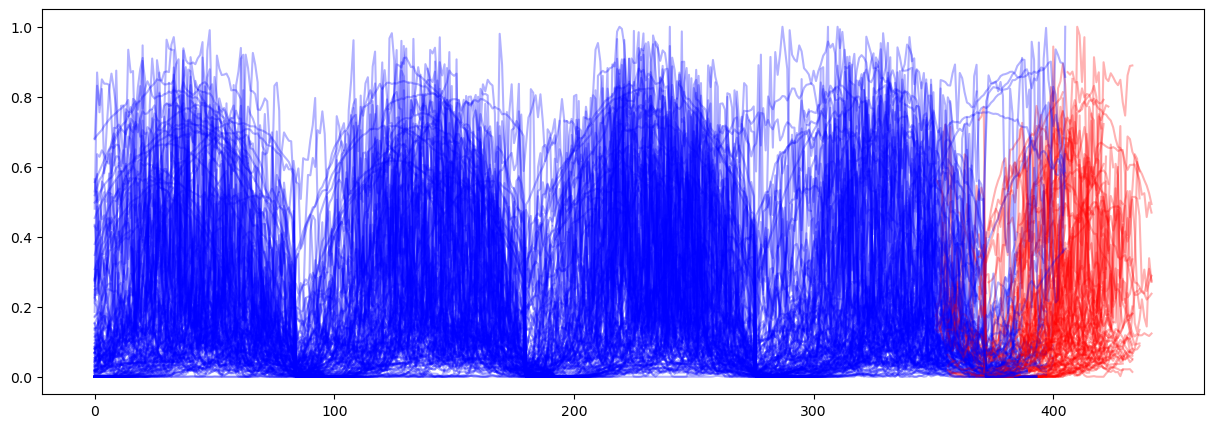

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))

for i in range(len(y_test)):
    plt.plot(time_train[i], y_train[i], color='b', alpha=0.3)
    plt.plot(time_test[i], y_test[i], color='r', alpha=0.3)

# NEED OPTIMIZATION HYPERPARAM ROUTINE BASED ON THIS FOLD
- Wrap into Multiout GP that keeps independent GPs similar to simple indep GPs - see [This Page for ModelList GPs (wrapper of indep. GPs) ](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/ModelList_GP_Regression.html)

In [27]:
import torch
torch.manual_seed(42)
import gpytorch
import optuna

from abc import ABC, abstractmethod


class HyperParameterOptimization(ABC):
    """ 
    Hyperparameter optimization using Optuna.

    Args:
        y_tr_list (list): list of training y values
        y_te_list (list): list of test y values
        x_tr_list (list): list of training x values
        x_te_list (list): list of test x values
    """

    def __init__(self, 
                 y_tr_list : list,
                 y_te_list : list,
                 x_tr_list : list,
                 x_te_list : list,
                 model_type : str = 'independent',
                 config : dict = None
                ):
        assert len(y_tr_list) == len(y_te_list) == len(x_tr_list) == len(x_te_list), "All lists must have the same length"
        assert model_type in ['independent', 'multitask'], "model_type must be either 'independent' or 'multitask'"
        if model_type == 'multitask':
            assert config is None, "config is not used for multitask models"
        elif model_type == 'independent':
            assert config is not None, "config must be provided for independent models"

        self.y_train = y_tr_list
        self.y_test = y_te_list
        self.x_train = x_tr_list
        self.x_test = x_te_list

    def sample_params_matern(self,
                             trial : optuna.trial.Trial
                             ):
        """ 
        Sample hyperparameters for the model using a Matern kernel.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            kernel (gpytorch.kernels.Kernel): kernel of the model
        """
        
        # sample hyperparameters
        
        lengthscale_shape = trial.suggest_float('matern_L_shape', 1, 10, step=1)
        lengthscale_rate = trial.suggest_float('matern_L_rate', 1, 10, step=1)

        signal_shape = trial.suggest_float('signal_matern_shape', 1, 10, step=1)
        signal_rate = trial.suggest_float('signal_matern_rate', 1, 10, step=1)

        # create kernel
        matern = MaternKernel(nu=3/2,
                              lengthscale_prior=gpytorch.priors.GammaPrior(lengthscale_shape, lengthscale_rate),
                              lengthscale_constraint=gpytorch.constraints.Positive()
                                )
        scaled_matern = ScaleKernel(matern,
                                    outputscale_prior=gpytorch.priors.GammaPrior(signal_shape, signal_rate),
                                    outputscale_constraint=gpytorch.constraints.Positive()
                                    )
        return scaled_matern
    
    def sample_params_periodic(self,
                               trial : optuna.trial.Trial
                              ):
        """
        Sample hyperparameters for the model using a periodic kernel.
        """
        lengthscale_shape = trial.suggest_float('periodic_L_shape', 1, 10, step=1)
        lengthscale_rate = trial.suggest_float('period_L_rate', 1, 10, step=1)

        period_shape = trial.suggest_float('period_P_shape', 1, 10, step=1)
        period_rate = trial.suggest_float('period__P_rate', 1, 10, step=1)

        signal_periodic_shape = trial.suggest_float('signal_periodic_shape', 1, 10, step=1)
        signal_periodic_rate = trial.suggest_float('signal_periodic_rate', 1, 10, step=1)

        periodic = PeriodicKernel(  lengthscale_prior=gpytorch.priors.GammaPrior(lengthscale_shape, lengthscale_rate),
                                    lengthscale_constraint=gpytorch.constraints.Positive(),
                                    period_prior=gpytorch.priors.GammaPrior(period_shape, period_rate),
                                    period_constraint=gpytorch.constraints.Positive()
                                    )
        scaled_periodic = ScaleKernel(periodic,
                                    outputscale_prior=gpytorch.priors.GammaPrior(signal_periodic_shape, signal_periodic_rate),
                                    outputscale_constraint=gpytorch.constraints.Positive()
                                    )
        return scaled_periodic
    
    
    def sample_params_quasi_periodic(self,
                                     trial : optuna.trial.Trial
                                    ):
        """
        Sample hyperparameters for the model using a quasi-periodic kernel.
        """
        matern = self.sample_params_matern(trial)
        periodic = self.sample_params_periodic(trial)

        product_kernel = ProductKernel(matern, periodic)
        quasi_periodic = AdditiveKernel(product_kernel, matern)

        return quasi_periodic
        
    def sample_params_likelihood(self,
                                 trial : optuna.trial.Trial
                                ):
        """
        Sample hyperparameters for the likelihood.
        """
        likelihood_scale = trial.suggest_int('likelihood_scale', 1, 60, step=5)        
        likelihood = BetaLikelihood_MeanParametrization(scale=likelihood_scale)
                                                        
        return likelihood

    def sample_mean(self, 
                    trial : optuna.trial.Trial):
        """
        Sample the mean of the model.
        """
        mean_type = trial.suggest_categorical('mean_type', ['constant', 'zero'])

        if mean_type == 'constant':
            return gpytorch.means.ConstantMean()
        elif mean_type == 'zero':
            return gpytorch.means.ZeroMean()

    def sample_model(self, x, y, trial : optuna.trial.Trial):
        """ 
        Sample the model parameters.
        """
        kernel = self.sample_params_quasi_periodic(trial)
        likelihood = self.sample_params_likelihood(trial)
        mean = self.sample_mean(trial)

        return kernel, likelihood, mean
    
    def fit(self, 
            model,
            x_train : torch.Tensor,
            y_train : torch.Tensor,
            n_iter : int,
            lr : float,
            verbose : bool = False):
        """ 
        Fit the model.
        """
            
        model.train()
        model.likelihood.train()
        
        elbo = gpytorch.mlls.VariationalELBO(model.likelihood, self, num_data=self.y_train.size(0))
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        
        print_freq = n_iter // 10
        
        for i in range(n_iter):
            
            optim.zero_grad()
            output = model(self.x_train)
            loss = -elbo(output, self.y_train)
            loss.backward()
            optim.step()
            
            if verbose and (i+1) % print_freq == 0:
                print(f'Iter {i+1}/{n_iter} - Loss: {loss.item()}')
        
        return model
    
    @abstractmethod
    def metric(self, y_dist, target):
        """
        Metric to optimize.
        """
        pass

    @abstractmethod    
    def objective(self, trial : optuna.trial.Trial):
        """
        Objective function to minimize.
        """
        pass


## Set up Sub-Model a